In [1]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

from torchvision.datasets import ImageFolder 
from torch.utils.data import DataLoader
import torch
from PIL import Image
from torch.utils.data import TensorDataset, DataLoader

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

/root/miniconda3/envs/myconda/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Random Seed:  999


In [2]:
labelName = ["bowl", "dog", "feel", "get", "I", "know", "must", "sick", "you", "zero"]

for name in labelName:
    pt_path = '/mnt/DCGAN_datasets/nonshuffle_diffusionDatasets_64_{}.pt'.format(name)
    pt = torch.load(pt_path)
    if name=='bowl':
        total_pt=pt
    else:
        total_pt=torch.cat((total_pt,pt),dim=0)
    print(total_pt.shape)

torch.Size([3066, 12289])
torch.Size([6202, 12289])
torch.Size([9304, 12289])
torch.Size([12385, 12289])
torch.Size([15390, 12289])
torch.Size([18325, 12289])
torch.Size([21363, 12289])
torch.Size([24410, 12289])
torch.Size([27431, 12289])
torch.Size([30448, 12289])


In [2]:
# torch.save(total_pt,"/mnt/DCGAN_datasets/nonshuffle_diffusionDatasets_64_total.pt") 
total_pt = torch.load("/mnt/DCGAN_datasets/nonshuffle_diffusionDatasets_64_total.pt") 
#total_pt = torch.load("/root/nonshuffle_diffusionDatasets_total.pt")

In [3]:
mixDataSets = total_pt[torch.randperm(total_pt.size()[0])] #shuffle,而且是有label的

In [4]:
torch.cuda.empty_cache()

In [5]:
trainingRatio = 0.8
batchSize=128
device = torch.device("cuda")

tranforms = transforms.Normalize(0,1)

rawTensorDataSets = mixDataSets

rawTensorDataSetsData = rawTensorDataSets[:,0:-1].to(dtype=torch.float32).to(device)
rawTensorDataSetsLabel = rawTensorDataSets[:,-1].to(dtype=torch.float32).to(device)

totalCount = rawTensorDataSets.shape[0] # must be 30448
trainingCount = int(totalCount * trainingRatio)

trainingData = rawTensorDataSets[0:trainingCount, 0:-1].to(dtype=torch.float32).to(device)
trainingLabel = rawTensorDataSets[0:trainingCount, -1].to(dtype=torch.float32).to(device)
validatingData = rawTensorDataSets[trainingCount:, 0:-1].to(dtype=torch.float32).to(device)
validatingLabel = rawTensorDataSets[trainingCount:, -1].to(dtype=torch.float32).to(device)

In [6]:
trainingDataSet = TensorDataset(trainingData, trainingLabel)
validatingDataSet = TensorDataset(validatingData, validatingLabel)

train_dataloader = DataLoader(trainingDataSet, batch_size=batchSize, shuffle=True)
val_dataloader = DataLoader(validatingDataSet, batch_size=batchSize, shuffle=True)

In [7]:
# resnet-18 

import torch
import torch.nn as nn
import torch.nn.functional as F

#定义残差块ResBlock

class ResBlock(nn.Module):
    def __init__(self, inchannel, outchannel, identity_downsample=None, stride=1):
        super(ResBlock, self).__init__()
        
        #这里定义了残差块内连续的2个卷积层
        self.conv1 = nn.Conv2d(inchannel,outchannel,kernel_size=3,stride=stride,padding=1)
        self.bn1 = nn.BatchNorm2d(outchannel)
        self.conv2 = nn.Conv2d(outchannel,outchannel,kernel_size=3,stride=1,padding=1)
        self.bn2 = nn.BatchNorm2d(outchannel)
        self.relu = nn.ReLU()
        self.identity_downsample = identity_downsample
            
    def forward(self, x):
        identity = x
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        
        # if identity_downsample is not None as default, then:
        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)
        
        x = x + identity
        x = self.relu(x)
        
        return x

In [8]:
class ResNet_18(nn.Module):
    
    def __init__(self, image_channels, num_classes):
        
        super(ResNet_18, self).__init__()
        # self.in_channels = 64
        self.conv1 = nn.Conv2d(image_channels, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        #resnet layers
        self.layer1 = self.__make_layer(64, 64, stride=1)
        self.layer2 = self.__make_layer(64, 128, stride=2)
        self.layer3 = self.__make_layer(128, 256, stride=2)
        self.layer4 = self.__make_layer(256, 512, stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)
        
    def identity_downsample(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1), 
            nn.BatchNorm2d(out_channels)
        )  
    
    def __make_layer(self, in_channels, out_channels, stride):
        
        identity_downsample = None #默认是none,即identity-free shortcut
        if stride != 1:
            identity_downsample = self.identity_downsample(in_channels, out_channels)
        #对于64-128.128-256.256-512的第一个block,有stride=2,且outchannel=2*inchannel；
        #其他的block,64-64的全部2个,64-128的第2个，128-256的第2个，256-512的第2个，都是outchannel=inchannel
            
        return nn.Sequential(
            ResBlock(in_channels, out_channels, identity_downsample=identity_downsample, stride=stride), 
            ResBlock(out_channels, out_channels)
        )
    
    def forward(self, x):
        x = x.reshape((-1, 3, 64, 64))
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        x = x.view(x.shape[0], -1)
        x = self.fc(x)
        return x 

    
model = ResNet_18(3,10)

device = torch.device("cuda:0" if torch.cuda.is_available () else "cpu")

model = model.to(device)

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

Epoch 1, Average Training Loss: 10.5635, Training Accuracy: 98.6575%, Validating Accuracy: 100.0000%
Epoch 2, Average Training Loss: 0.0469, Training Accuracy: 100.0000%, Validating Accuracy: 100.0000%
Epoch 3, Average Training Loss: 0.0316, Training Accuracy: 100.0000%, Validating Accuracy: 100.0000%
Epoch 4, Average Training Loss: 0.0168, Training Accuracy: 100.0000%, Validating Accuracy: 100.0000%
Epoch 5, Average Training Loss: 0.0115, Training Accuracy: 100.0000%, Validating Accuracy: 100.0000%
Epoch 6, Average Training Loss: 0.0089, Training Accuracy: 100.0000%, Validating Accuracy: 100.0000%
Epoch 7, Average Training Loss: 0.0070, Training Accuracy: 100.0000%, Validating Accuracy: 100.0000%
Epoch 8, Average Training Loss: 0.0057, Training Accuracy: 100.0000%, Validating Accuracy: 100.0000%
Epoch 9, Average Training Loss: 0.0048, Training Accuracy: 100.0000%, Validating Accuracy: 100.0000%
Epoch 10, Average Training Loss: 0.0041, Training Accuracy: 100.0000%, Validating Accuracy:

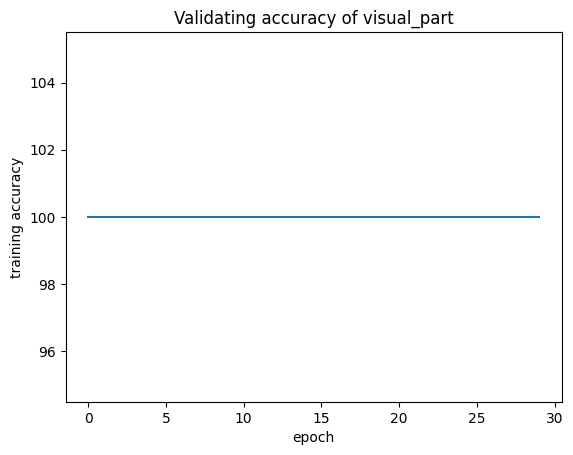

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

acc_val=[]

epoch = 30

iterr=[]
for i in range(epoch):
    iterr.append(i)
    
for epoch in range(epoch):
    statisticLoss = 0.0
    total = 0
    correct = 0
    
    # Training
    for i, (features, labels) in enumerate(train_dataloader):
        optimizer.zero_grad()
        outputs = model(features)
        loss = criterion(outputs, labels.long())
        loss.backward()
        optimizer.step()

        statisticLoss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        torch.cuda.empty_cache()

    trainingAcc = 100 * correct / total
    
    # Validating
    total = 0
    correct = 0
    with torch.no_grad():
        for i, (features, labels) in enumerate(val_dataloader):
            outputs = model(features)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    validatingAcc = 100 * correct / total
    acc_val.append(validatingAcc)

    print("Epoch %d, Average Training Loss: %.4lf, Training Accuracy: %.4lf%%, Validating Accuracy: %.4lf%%" %(epoch+1, statisticLoss, trainingAcc, validatingAcc))

torch.save(model, "/root/DCGAN_64_pure_vision.pth")


plt.figure()
plt.plot(iterr,acc_val)
plt.title('Validating accuracy of visual_part')
plt.xlabel('epoch')
plt.ylabel('training accuracy')
plt.savefig('/mnt/newModel/DCGAN_64_pure_vision.png')
plt.show()